In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
if os.path.exists("../input/rsna-miccai-brain-tumor-radiogenomic-classification"):
    data_directory = '../input/rsna-miccai-voxel-128-dataset/voxel'
    pytorch3dpath = "../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D"
else:
    data_directory = '/media/roland/data/kaggle/rsna-miccai-brain-tumor-radiogenomic-classification'
    pytorch3dpath = "EfficientNet-PyTorch-3D"
    
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 64

sys.path.append(pytorch3dpath)
from efficientnet_pytorch_3d import EfficientNet3D

## Functions to load images

In [3]:
def load_images_processed(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", rotate=0):
  
  if os.path.exists(f"{data_directory}/{split}/{scan_id}/{mri_type}.npy"):
    file = f"{data_directory}/{split}/{scan_id}/{mri_type}.npy"
    array = np.load(file) 
    data = array
  else:
        data =  np.zeros( (128,128,128) , dtype=int)
  
  return np.expand_dims(data,0)

In [4]:
'''def Load_dicom_image(path, img_size=SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def Load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([Load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

a = Load_dicom_images_3d("00000")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))'''

'def Load_dicom_image(path, img_size=SIZE, voi_lut=True, rotate=0):\n    dicom = pydicom.read_file(path)\n    data = dicom.pixel_array\n    if voi_lut:\n        data = apply_voi_lut(dicom.pixel_array, dicom)\n    else:\n        data = dicom.pixel_array\n        \n    if rotate > 0:\n        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]\n        data = cv2.rotate(data, rot_choices[rotate])\n        \n    data = cv2.resize(data, (img_size, img_size))\n    return data\n\n\ndef Load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", rotate=0):\n\n    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), \n               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r\'[^0-9]|[0-9]+\', var)])\n\n    middle = len(files)//2\n    num_imgs2 = num_imgs//2\n    p1 = max(0, middle - num_imgs2)\n    p2 = min(len(files), middle + num_imgs2)\n    img3d = np.stack([Loa

In [5]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(99)

## train / test splits

In [6]:
train_df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=24, 
    stratify=train_df["MGMT_value"],
)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [7]:
df_train.tail()

,BraTS21ID,MGMT_value
68,106,1
547,801,1
101,151,0
498,729,0
537,789,1


## Model and training classes

In [8]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train", augment=False):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
        self.augment = augment
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_images_processed(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            if self.augment:
                rotation = np.random.randint(0,4)
            else:
                rotation = 0

            data = load_images_processed(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train", rotate=rotation)

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out
    

In [10]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            # if True:
            # if self.best_valid_score < valid_auc: 
            if self.best_valid_score > valid_loss: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_loss, self.lastmodel
                )
                self.best_valid_score = valid_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_loss += loss.detach().item()

            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

## train models

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values,
        augment=True
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=4,
        shuffle=True,
        num_workers=8,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )

    model = Model()
    model.to(device)

    #checkpoint = torch.load("best-model-all-auc0.555.pth")
    #model.load_state_dict(checkpoint["model_state_dict"])

    #print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        10, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        10,
    )
    
    return trainer.lastmodel

modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

(468, 3) (117, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
289,418,0,FLAIR
119,178,1,FLAIR
228,331,1,FLAIR
567,834,0,FLAIR
86,133,0,FLAIR


EPOCH: 1
[Epoch Train: 1] loss: 0.7650, time: 517.00 s            
[Epoch Valid: 1] loss: 0.6935, auc: 0.4513, time: 33.00 s
auc improved from inf to 0.6935. Saved model to 'FLAIR-e1-loss0.693-auc0.451.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6979, time: 501.00 s            
[Epoch Valid: 2] loss: 0.6934, auc: 0.5221, time: 32.00 s
auc improved from 0.6935 to 0.6934. Saved model to 'FLAIR-e2-loss0.693-auc0.522.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.7121, time: 501.00 s            
[Epoch Valid: 3] loss: 0.6938, auc: 0.4322, time: 32.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.7025, time: 505.00 s            
[Epoch Valid: 4] loss: 0.6914, auc: 0.6092, time: 32.00 s
auc improved from 0.6934 to 0.6914. Saved model to 'FLAIR-e4-loss0.691-auc0.609.pth'
EPOCH: 5
[Epoch Train: 5] loss: 0.7133, time: 493.00 s            
[Epoch Valid: 5] loss: 0.6857, auc: 0.4851, time: 32.00 s
auc improved from 0.6914 to 0.6857. Saved model to 'FLAIR-e5-loss0.686-auc0.485.pth'
EPOCH: 6
[Epoch Train: 6] loss: 0.6960

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
289,418,0,T1w
119,178,1,T1w
228,331,1,T1w
567,834,0,T1w
86,133,0,T1w


EPOCH: 1
[Epoch Train: 1] loss: 0.7535, time: 509.00 s            
[Epoch Valid: 1] loss: 0.6911, auc: 0.4463, time: 32.00 s
auc improved from inf to 0.6911. Saved model to 'T1w-e1-loss0.691-auc0.446.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.7126, time: 506.00 s            
[Epoch Valid: 2] loss: 0.6914, auc: 0.5012, time: 32.00 s
EPOCH: 3
[Epoch Train: 3] loss: 0.7045, time: 506.00 s            
[Epoch Valid: 3] loss: 0.6970, auc: 0.4830, time: 32.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6999, time: 496.00 s            
[Epoch Valid: 4] loss: 0.6831, auc: 0.5700, time: 32.00 s
auc improved from 0.6911 to 0.6831. Saved model to 'T1w-e4-loss0.683-auc0.570.pth'
EPOCH: 5
[Epoch Train: 5] loss: 0.6986, time: 495.00 s            
[Epoch Valid: 5] loss: 0.8511, auc: 0.5202, time: 32.00 s
EPOCH: 6
[Epoch Train: 6] loss: 0.6982, time: 503.00 s            
[Epoch Valid: 6] loss: 0.7461, auc: 0.5580, time: 32.00 s
EPOCH: 7
[Epoch Train: 7] loss: 0.7025, time: 505.00 s            
[Epoch Valid: 7] los

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
289,418,0,T1wCE
119,178,1,T1wCE
228,331,1,T1wCE
567,834,0,T1wCE
86,133,0,T1wCE


EPOCH: 1
[Epoch Train: 1] loss: 0.7546, time: 495.00 s            
[Epoch Valid: 1] loss: 0.6931, auc: 0.6028, time: 44.00 s
auc improved from inf to 0.6931. Saved model to 'T1wCE-e1-loss0.693-auc0.603.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.7147, time: 500.00 s            
[Epoch Valid: 2] loss: 0.6911, auc: 0.4094, time: 32.00 s
auc improved from 0.6931 to 0.6911. Saved model to 'T1wCE-e2-loss0.691-auc0.409.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6973, time: 510.00 s            
[Epoch Valid: 3] loss: 0.6890, auc: 0.5392, time: 32.00 s
auc improved from 0.6911 to 0.6890. Saved model to 'T1wCE-e3-loss0.689-auc0.539.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.6988, time: 504.00 s            
[Epoch Valid: 4] loss: 2.5104, auc: 0.4072, time: 32.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.7042, time: 500.00 s            
[Epoch Valid: 5] loss: 3.2365, auc: 0.4136, time: 32.00 s
EPOCH: 6
[Epoch Train: 6] loss: 0.6981, time: 500.00 s            
[Epoch Valid: 6] loss: 6.0032, auc: 0.4417, time: 33.00 

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
289,418,0,T2w
119,178,1,T2w
228,331,1,T2w
567,834,0,T2w
86,133,0,T2w


EPOCH: 1
[Epoch Train: 1] loss: 0.7629, time: 511.00 s            
[Epoch Valid: 1] loss: 0.6985, auc: 0.5174, time: 33.00 s
auc improved from inf to 0.6985. Saved model to 'T2w-e1-loss0.699-auc0.517.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.7054, time: 511.00 s            
[Epoch Valid: 2] loss: 0.7039, auc: 0.4267, time: 33.00 s
EPOCH: 3
[Epoch Train: 3] loss: 0.7037, time: 512.00 s            
[Epoch Valid: 3] loss: 0.6929, auc: 0.4915, time: 32.00 s
auc improved from 0.6985 to 0.6929. Saved model to 'T2w-e3-loss0.693-auc0.492.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.7002, time: 512.00 s            
[Epoch Valid: 4] loss: 1.1144, auc: 0.5023, time: 32.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.7052, time: 502.00 s            
[Epoch Valid: 5] loss: 0.7868, auc: 0.5556, time: 33.00 s
EPOCH: 6
[Epoch Train: 6] loss: 0.7001, time: 509.00 s            
[Epoch Valid: 6] loss: 1.5389, auc: 0.3402, time: 32.00 s
EPOCH: 7
[Epoch Train: 7] loss: 0.6993, time: 498.00 s            
[Epoch Valid: 7] los

## Predict function

In [12]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

## Ensemble for validation

Predict: FLAIR-e5-loss0.686-auc0.485.pth FLAIR (117, 3)
Predict: T1w-e4-loss0.683-auc0.570.pth T1w (117, 3)
Predict: T1wCE-e3-loss0.689-auc0.539.pth T1wCE (117, 3)
Predict: T2w-e9-loss0.692-auc0.509.pth T2w (117, 3)
Validation ensemble AUC: 0.5653


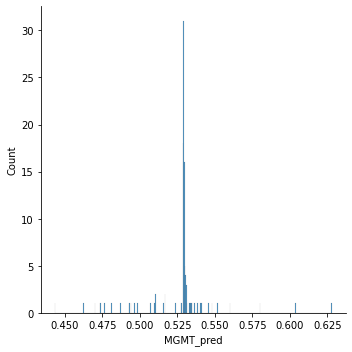

In [13]:
df_valid = df_valid.set_index("BraTS21ID")
df_valid["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid["MGMT_pred"] += pred["MGMT_value"]
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])

## Ensemble for submission

In [14]:
submission = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv', index_col="BraTS21ID")

submission["MGMT_value"] = 0
for m, mtype in zip(modelfiles, mri_types):
    pred = predict(m, submission, mtype, split="test")
    submission["MGMT_value"] += pred["MGMT_value"]

submission["MGMT_value"] /= len(modelfiles)
submission["MGMT_value"].to_csv("submission.csv")

Predict: FLAIR-e5-loss0.686-auc0.485.pth FLAIR (87, 1)
Predict: T1w-e4-loss0.683-auc0.570.pth T1w (87, 2)
Predict: T1wCE-e3-loss0.689-auc0.539.pth T1wCE (87, 2)
Predict: T2w-e9-loss0.692-auc0.509.pth T2w (87, 2)


In [15]:
submission

,MGMT_value,MRI_Type
BraTS21ID,,
1,0.529571,T2w
13,0.533304,T2w
15,0.529467,T2w
27,0.529804,T2w
37,0.529494,T2w
...,...,...
826,0.529865,T2w
829,0.415687,T2w
833,0.514630,T2w


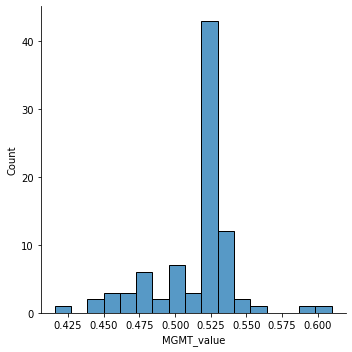

In [16]:
sns.displot(submission["MGMT_value"])